In [491]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import pathlib
from skimage import color
import random

In [253]:
defaultPath = r'G:\Documents\ReferenceBooks\1-DigitalImageProcessing\HW3\Images\\'

### Convert image to FFT

In [362]:
class GrayImageFFT:
    def load_gray_from_file(self,defaultPath,fileName):
        self.image = plt.imread(defaultPath+fileName)
        self.image = color.rgb2gray(self.image)

    def load_from_array(self,array):
        self.image = array
        
    def fft(self):
        self.fft=np.fft.fft2(self.image)
        self.fft = np.fft.fftshift(self.fft)
        self.magnitude = 20*np.log(np.abs(self.fft))
        
        self.filtered = self.fft
        return self.magnitude
    
    def apply_filter(self,custom_filter):
        self.filtered = self.filtered*custom_filter
        
    def get_filtered_image(self):
        shifted= np.fft.ifftshift(self.filtered)
        return np.abs( np.fft.ifft2(shifted))

### Notch Filter

In [335]:
def get_filter_from_point(shape,d0,u,v):
    length = shape[0]
    width = shape[1]
    my_array=np.indices((length,width))
    distance_uv = np.sqrt((my_array[0] -length/2 + u)**2 + (my_array[1]-width/2+v)**2)
    distance_muv = np.sqrt((my_array[0] -length/2 - u)**2 + (my_array[1]-width/2-v)**2)
    bandpass_filter= np.logical_or(distance_uv<=d0,distance_muv<=d0)
    notch_filter = np.invert( bandpass_filter)
    return notch_filter

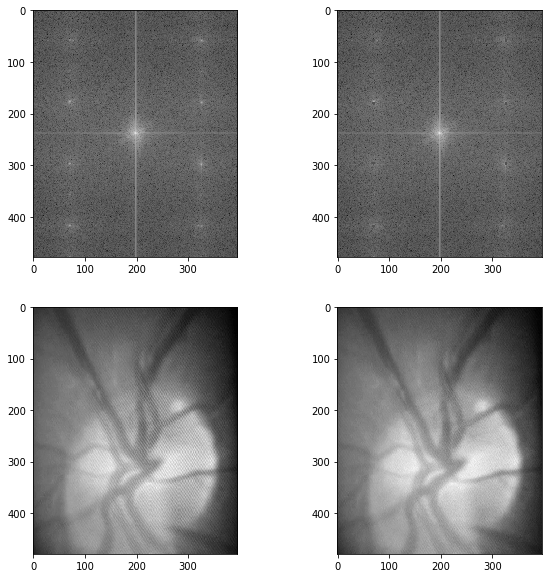

In [336]:
imagefft=GrayImageFFT()
imagefft.load_gray_from_file(defaultPath,'Vessel.png')

imagefft.fft()


H1 = get_filter_from_point(vessel.shape,  3,180, 128)
H2 = get_filter_from_point(vessel.shape, 3,-180, 128)
H3 = get_filter_from_point(vessel.shape, 3, 58, 128)
H4 = get_filter_from_point(vessel.shape, 3, -58, 128)
H5 = get_filter_from_point(vessel.shape,2,120,128)
H6 = get_filter_from_point(vessel.shape,2,-120,128)

NotchFilter = H1*H2*H3*H4*H5*H6

imagefft.apply_filter(NotchFilter)
back_image = imagefft.get_filtered_image()

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(dft,cmap='gray')

plt.subplot(2,2,2)
plt.imshow(imagefft.magnitude*NotchFilter,cmap='gray')

plt.subplot(2,2,3)
plt.imshow(vessel,cmap='gray')

plt.subplot(2,2,4)
plt.imshow(back_image,cmap='gray')

plt.imsave(defaultPath+'VesselDFTAfterFix.png',imagefft.magnitude*NotchFilter,cmap='gray')
plt.imsave(defaultPath+'VesselDFT.png',imagefft.magnitude,cmap='gray')
plt.imsave(defaultPath+'VesselNotchFilter.png',back_image,cmap='gray')

### Gaussian Smoothing Filtering

In [332]:
def gaussian_lowpass_filter(shape,sigma):
    indices=np.indices(dimensions=shape)
    distance=np.sqrt((indices[0]-shape[0]/2)**2+(indices[1]-shape[1]/2)**2)
    return np.exp(-1*distance**2/(2*sigma**2))

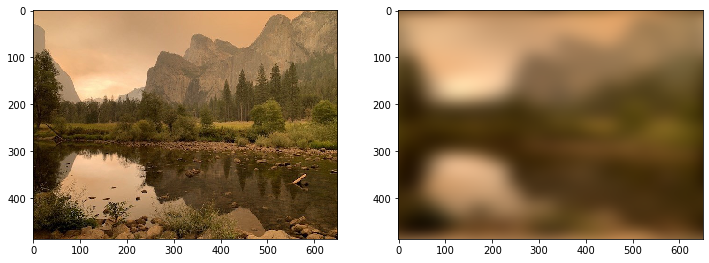

In [367]:
nature=plt.imread(defaultPath+'Nature.jpg')

guassian = gaussian_lowpass_filter((nature.shape[0],nature.shape[1]),5)

nature_array = []
for i in range(3):
    imageDim0 = GrayImageFFT()
    imageDim0.load_from_array(nature[:,:,i])
    imageDim0.fft()
    imageDim0.apply_filter(guassian)
    nature_array.append(imageDim0.get_filtered_image())

gaussian_nature = np.zeros(nature.shape)
gaussian_nature[:,:,0] = nature_array[0]
gaussian_nature[:,:,1] = nature_array[1]
gaussian_nature[:,:,2] = nature_array[2]
gaussian_nature = (gaussian_nature-gaussian_nature.min())/(gaussian_nature.max()-gaussian_nature.min())

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(nature)
plt.subplot(2,2,2)
plt.imshow(gaussian_nature)

plt.imsave(defaultPath+'NatureBlur.jpg',gaussian_nature)

### Gaussian Deblur 

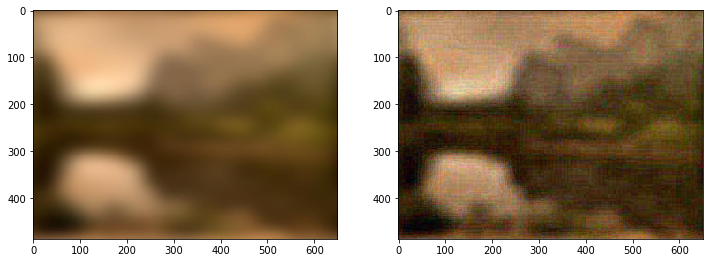

In [386]:
nature=plt.imread(defaultPath+'NatureBlur.jpg')

gauss =1/(1e-1+gaussian_lowpass_filter((nature.shape[0],nature.shape[1]),5))

nature_array = []
for i in range(3):
    imageDim0 = GrayImageFFT()
    imageDim0.load_from_array(nature[:,:,i])
    imageDim0.fft()
    imageDim0.apply_filter(guassian)
    nature_array.append(imageDim0.get_filtered_image())

gaussian_nature = np.zeros(nature.shape)
gaussian_nature[:,:,0] = nature_array[0]
gaussian_nature[:,:,1] = nature_array[1]
gaussian_nature[:,:,2] = nature_array[2]
gaussian_nature = (gaussian_nature-gaussian_nature.min())/(gaussian_nature.max()-gaussian_nature.min())

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(nature)
plt.subplot(1,2,2)
plt.imshow(gaussian_nature)

plt.imsave(defaultPath+'NatureDeblur.jpg',gaussian_nature)

### White Noise or Random Noise

In [504]:
def random_noise(image,noise_percentage,saltPercent):
    img_noise = np.copy(image)
    noise_num = np.int(np.round(noise_percentage * img_noise.size))
    x=np.random.randint(0,img_noise.shape[0],noise_num)
    y=np.random.randint(0,img_noise.shape[1],noise_num)

    salt_vs_pepper = np.random.binomial(1,saltPercent,size=noise_num)*255
    img_noise[x,y,0] = salt_vs_pepper
    img_noise[x,y,1] = salt_vs_pepper
    img_noise[x,y,2] = salt_vs_pepper
    return img_noise

In [505]:
def median_filter(data):
    new_image = np.zeros(data.shape)
    for k in range(0,data.shape[2]):
        for i in range(1, data.shape[0]-1):
            for j in range(1, data.shape[1]-1):
                temp = [
                   data[i-1, j-1,k],
                   data[i-1, j,k],
                   data[i-1, j + 1,k],
                   data[i, j-1,k],
                   data[i, j,k],
                   data[i, j + 1,k],
                   data[i + 1, j-1,k],
                   data[i + 1, j,k],
                   data[i + 1, j + 1,k]]
                temp = sorted(temp)
                new_image[i, j,k]= temp[4]
    return new_image

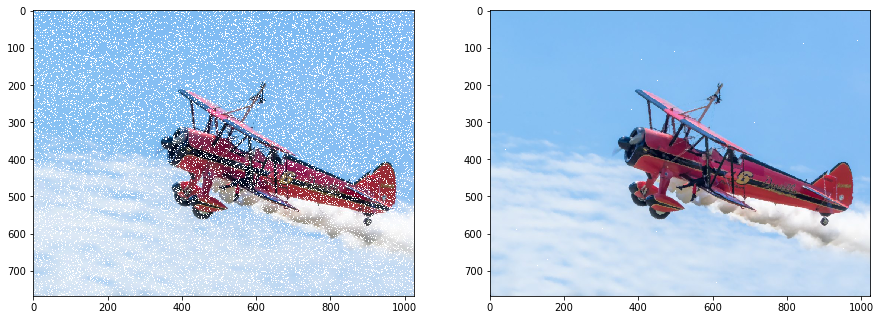

In [514]:
airplane=plt.imread(defaultPath+'Airplane.jpg')
noisy_image = random_noise(airplane,0.05,1)
denoise_image = median_filter(median_filter(noisy_image))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(noisy_image)
plt.subplot(1,2,2)
plt.imshow(denoise_image/255)

plt.imsave(defaultPath+'Airplane_WhiteNoise.jpg',noisy_image)
plt.imsave(defaultPath+'Airplane_WhiteNoise_Fixed.jpg',denoise_image/255)

### Salt And Pepper Noise

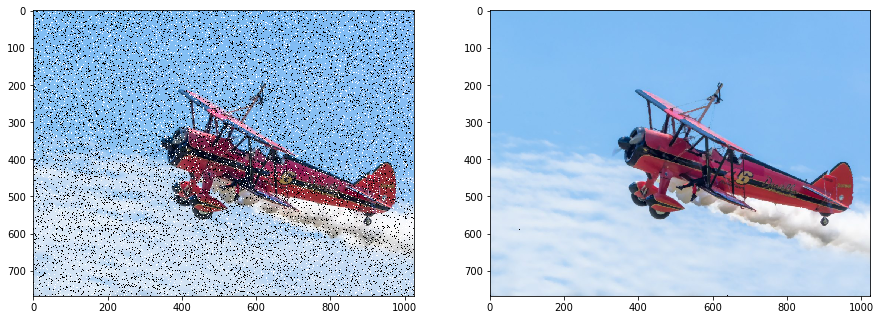

In [515]:
airplane=plt.imread(defaultPath+'Airplane.jpg')
noisy_image = random_noise(airplane,0.05,0.4)
denoise_image = median_filter(median_filter(noisy_image))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(noisy_image)
plt.subplot(1,2,2)
plt.imshow(denoise_image/255)

plt.imsave(defaultPath+'Airplane_SaltPepperNoise.jpg',noisy_image)
plt.imsave(defaultPath+'Airplane_SaltPepperNoise_Fixed.jpg',denoise_image/255)

### Histogram Matching

In [627]:
def histogram_matching(src, image):
    old_shape = src.shape
    source = src.ravel()
    image = image.ravel()
    
    source_values, index, source_counts = np.unique(src, return_inverse=True,return_counts=True)
    image_values, image_counts = np.unique(image, return_counts=True)

    s_cum = np.cumsum(source_counts).astype(np.float64)
    s_cum /= s_cum[-1]
    t_cum = np.cumsum(image_counts).astype(np.float64)
    t_cum /= t_cum[-1]

    intercept_result = np.interp(s_cum, t_cum, image_values)

    return interp_t_values[index].reshape(oldshape)

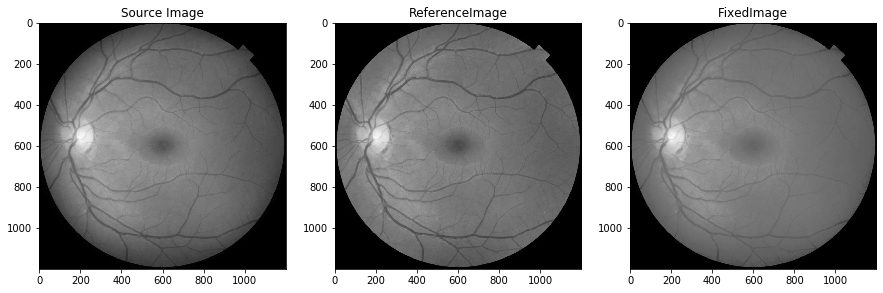

In [628]:
imageref=eyeref=plt.imread(defaultPath+'eyeref.png')
imageref = np.round(color.rgb2gray(imageref)*255)

image2=plt.imread(defaultPath+'eye.png')
image2 = np.round(color.rgb2gray(image2)*255)

matched = hist_match(image2,imageref)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(image2,cmap='gray')
plt.title('Source Image')

plt.subplot(1,3,2)
plt.imshow(imageref,cmap='gray')
plt.title('ReferenceImage')

plt.subplot(1,3,3)
plt.imshow(matched,cmap='gray')
plt.title('FixedImage')

plt.imsave(defaultPath+'EyeHistogram.png',matched)